In [39]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')


import os
import pandas as pd
import numpy as np
from fredapi import Fred
import missingno
import matplotlib.pyplot as plt 

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score ,confusion_matrix ,precision_score, recall_score, f1_score, classification_report ,roc_curve, roc_auc_score ,roc_curve, auc, ConfusionMatrixDisplay , RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

plt.style.use('ggplot')


from utils.extract_data import get_FRED_series
from utils.time_series_preprocessing import gathering_data_for_modeling , resample_time_series

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
fred_series = get_FRED_series()
infos = fred_series['Infos']
tickers_series = fred_series["Data"] 

In [41]:
from utils.time_series_preprocessing import *


def gathering_data_for_modeling(tickers_dataset,
                                infos_dataset,
                                chosen_target,
                                frequency_ajustment='higher_to_lower',
                                begin_date=None,
                                end_date=None,
                                include_seasonal_ajusted_series=True,
                                agg_method = "last",
                                fillna_method ='forward_fill',
                                **dict_kwargs):
    
    infos_dictionary = get_data_dictionary(tickers_dataset,infos_dataset,**dict_kwargs)
    

    category_frequencies = {"Y": 4,"Q": 3,"M": 2,"D":1}
    
    # Define a custom key function to map category labels to frequencies
    
    def custom_key(category):
        return category_frequencies.get(category, 0) 
    
    max_frequency = max(infos_dataset['frequency_short'], key=custom_key)
    
    
    min_frequeny =  min(infos_dataset['frequency_short'], key=custom_key)



    if frequency_ajustment == 'higher_to_lower':
        chosen_freq = max_frequency
    elif frequency_ajustment == 'lower_to_higher':
        chosen_freq = min_frequeny
    elif frequency_ajustment == 'target_frequency':
        chosen_freq = infos_dataset.query(f"id == '{chosen_target}' ")['frequency_short'].unique()[0]
    else:
        raise ValueError("Unsupported frequency ajustment. Choose from ''higher_to_lower' ,'lower_to_higher' ,'target_frequency'")

    
    target_series = infos_dictionary[chosen_target]['ts'].copy()


    trasnformed = []



    for k in infos_dictionary.keys():
        
        
        serie = infos_dictionary[k]['ts']


        if begin_date is None:
            start = target_series.index.min()
        else:
            start = begin_date
        if end_date is None:
            end = target_series.index.max()
        else:
            end = end_date
        
        serie = serie[start:end]



        if type(agg_method) == str: 
            resampled_ts = resample_time_series(serie,desired_freq=chosen_freq,aggregation_method=agg_method)
            
        elif type(agg_method) == dict:
            for agg in agg_method.keys():
                if k in agg_method[agg]:
                    resampled_ts = resample_time_series(serie,desired_freq=chosen_freq,aggregation_method=agg)
                else:
                    pass
            
        transformed_serie = resampled_ts.copy()
        print(resampled_ts)
        if type(fillna_method) == str: 
            transformed_serie = fillna_time_series(transformed_serie,fill_method=fillna_method)
        elif type(fillna_method) == dict:
            for method in fillna_method.keys():
                if k in fillna_method[agg]:
                    transformed_serie = fillna_time_series(transformed_serie,fill_method=method)
                else:
                    pass
         
        transformed_serie= transformed_serie.reset_index().rename(columns={"index":"date"})

        trasnformed.append(transformed_serie)
    
    
    #df_complete = pd.concat(trasnformed)
    df_complete  = reduce(lambda left, right: pd.merge(left, right, on='date', how='outer'), trasnformed)


    # df_complete=df_complete.reset_index().rename(columns={'index':"date"})
    
    return(df_complete)
        

In [42]:
resample_time_series(tickers_series['USREC'],'Q')

USREC
1854-12-31    1.0
1855-03-31    0.0
1855-06-30    0.0
1855-09-30    0.0
1855-12-31    0.0
...           ...
2022-09-30    0.0
2022-12-31    0.0
2023-03-31    0.0
2023-06-30    0.0
2023-09-30    0.0

[676 rows x 1 columns]

In [43]:
main_dataset = gathering_data_for_modeling(tickers_series,
                            infos,
                            chosen_target="USREC",
                            frequency_ajustment='higher_to_lower',begin_date='1960-01-01' ,
                            agg_method='last')

            USREC
1960-03-31    0.0
1960-06-30    1.0
1960-09-30    1.0
1960-12-31    1.0
1961-03-31    0.0
...           ...
2022-09-30    0.0
2022-12-31    0.0
2023-03-31    0.0
2023-06-30    0.0
2023-09-30    0.0

[255 rows x 1 columns]
                GDPC1
1960-03-31   3517.181
1960-06-30   3498.246
1960-09-30   3515.385
1960-12-31   3470.278
1961-03-31   3493.703
...               ...
2022-06-30  21708.160
2022-09-30  21851.134
2022-12-31  21989.981
2023-03-31  22112.329
2023-06-30  22225.350

[254 rows x 1 columns]
               PIECTR
1960-03-31   2539.890
1960-06-30   2555.375
1960-09-30   2557.793
1960-12-31   2549.358
1961-03-31   2560.952
...               ...
2022-06-30  15287.368
2022-09-30  15429.189
2022-12-31  15411.303
2023-03-31  15540.775
2023-06-30  15630.370

[254 rows x 1 columns]
            PRS85006013
1960-03-31       46.061
1960-06-30       46.114
1960-09-30       45.808
1960-12-31       45.573
1961-03-31       45.407
...                 ...
2022-06-30      

In [44]:
main_dataset['USREC'].value_counts()

main_dataset.shape

(255, 21)

In [45]:
print("NAs proportion since 1960")

print(main_dataset.isna().sum()/main_dataset.shape[0])

print("#"*100)

print("NAs proportion since 1970")

print(main_dataset[main_dataset['date']>'1970-01-01'].isna().sum()/main_dataset.shape[0])

print("#"*100)

print("NAs proportion since 1980")

print(main_dataset[main_dataset['date']>'1980-01-01'].isna().sum()/main_dataset.shape[0])

print("#"*100)

print("NAs proportion since 1986")

print(main_dataset[main_dataset['date']>'1986-01-01'].isna().sum()/main_dataset.shape[0])

print("#"*100)


print("NAs proportion since 1990")

print(main_dataset[main_dataset['date']>'1990-01-01'].isna().sum()/main_dataset.shape[0])

print("#"*100)


NAs proportion since 1960
date            0.000000
USREC           0.000000
GDPC1           0.003922
PIECTR          0.003922
PRS85006013     0.003922
IPB50001SQ      0.000000
CQRMTSPL        0.113725
T10Y3M          0.345098
T10Y2Y          0.254902
BAMLH0A0HYM2    0.576471
BAA10Y          0.407843
AAAFF           0.360784
T10YIE          0.674510
T5YIE           0.674510
VIXCLS          0.470588
GVZCLS          0.756863
OVXCLS          0.741176
ATLSBUSRGEP     0.890196
ATLSBUEGEP      0.890196
ATLSBUSRGUP     0.890196
ATLSBUEGUP      0.890196
dtype: float64
####################################################################################################
NAs proportion since 1970
date            0.000000
USREC           0.000000
GDPC1           0.003922
PIECTR          0.003922
PRS85006013     0.003922
IPB50001SQ      0.000000
CQRMTSPL        0.003922
T10Y3M          0.188235
T10Y2Y          0.098039
BAMLH0A0HYM2    0.419608
BAA10Y          0.250980
AAAFF           0.203922
T10YIE 

In [46]:
main_dataset[main_dataset['date'] < '2023-05-01'].tail()

date  USREC      GDPC1     PIECTR  PRS85006013  IPB50001SQ  \
248 2022-03-31    0.0  21738.871  15364.455      114.469    101.7258   
249 2022-06-30    0.0  21708.160  15287.368      115.524    102.7529   
250 2022-09-30    0.0  21851.134  15429.189      116.275    103.2985   
251 2022-12-31    0.0  21989.981  15411.303      116.915    102.6556   
252 2023-03-31    0.0  22112.329  15540.775      117.746    102.5914   

      CQRMTSPL  T10Y3M  T10Y2Y  BAMLH0A0HYM2  ...  AAAFF  T10YIE  T5YIE  \
248  1494872.0    1.80    0.04          3.43  ...   3.05    2.84   3.34   
249  1470081.0    1.26    0.06          5.87  ...   2.61    2.33   2.58   
250  1479648.0    0.50   -0.39          5.43  ...   1.83    2.15   2.14   
251  1485569.0   -0.54   -0.53          4.81  ...   0.37    2.30   2.33   
252  1489668.0   -1.37   -0.58          4.58  ...  -0.45    2.32   2.40   

     VIXCLS  GVZCLS  OVXCLS  ATLSBUSRGEP  ATLSBUEGEP  ATLSBUSRGUP  ATLSBUEGUP  
248   20.56   20.25   57.66        5.649       2.399        4.424       5.154  
249   28.71   19.61   48.90        5.832       1.872        4.750       4.867  
250   31.62   19.52   55.69        4.926       1.401        4.134       5.515  
251   21.67   16.25   41.26        5.419       0.842        4.443       4.277  
252   18.70   17.31   40.34        5.086       1.364        4.313       4.286  

[5 rows x 21 columns]

In [47]:
main_dataset.to_csv("data/dataset_1960_quarterly.csv")

In [84]:
dataset_1986 =  main_dataset[(main_dataset['date'] >'1986-01-01') & (main_dataset['date'] < '2023-05-01')]

<AxesSubplot:title={'center':'USREC'}, xlabel='date'>

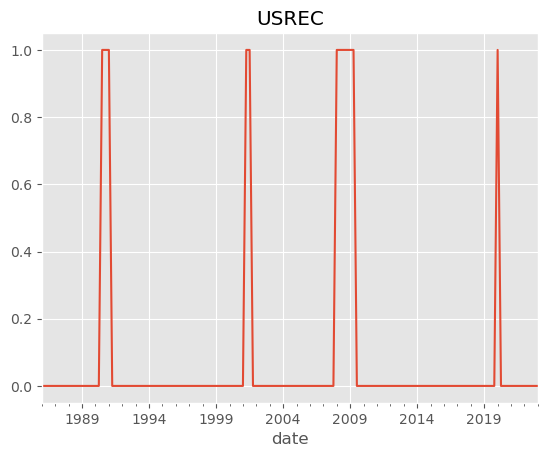

In [85]:
dataset_1986.set_index("date")['USREC'].plot(title='USREC')

In [86]:
dataset_1986.drop(['ATLSBUSRGEP','ATLSBUEGEP','ATLSBUSRGUP','ATLSBUEGUP'],axis=1,inplace=True) # few data available

In [87]:
dataset_1986

date  USREC      GDPC1     PIECTR  PRS85006013  IPB50001SQ  \
104 1986-03-31    0.0   8749.127   6319.018       77.992     55.2680   
105 1986-06-30    0.0   8788.524   6393.426       78.242     54.9453   
106 1986-09-30    0.0   8872.601   6435.490       78.859     55.1608   
107 1986-12-31    0.0   8920.193   6465.314       79.354     55.7873   
108 1987-03-31    0.0   8986.367   6492.639       79.910     56.5229   
..         ...    ...        ...        ...          ...         ...   
248 2022-03-31    0.0  21738.871  15364.455      114.469    101.7258   
249 2022-06-30    0.0  21708.160  15287.368      115.524    102.7529   
250 2022-09-30    0.0  21851.134  15429.189      116.275    103.2985   
251 2022-12-31    0.0  21989.981  15411.303      116.915    102.6556   
252 2023-03-31    0.0  22112.329  15540.775      117.746    102.5914   

        CQRMTSPL  T10Y3M  T10Y2Y  BAMLH0A0HYM2  BAA10Y  AAAFF  T10YIE  T5YIE  \
104   632220.850    0.86    0.47           NaN    2.92   0.67     NaN    NaN   
105   641389.255    1.22    0.54           NaN    2.81   1.24     NaN    NaN   
106   651578.388    2.11    1.07           NaN    2.75   1.99     NaN    NaN   
107   655969.692    1.40    0.88           NaN    2.76  -5.82     NaN    NaN   
108   659097.181    1.72    0.97           NaN    2.19   2.24     NaN    NaN   
..           ...     ...     ...           ...     ...    ...     ...    ...   
248  1494872.000    1.80    0.04          3.43    1.93   3.05    2.84   3.34   
249  1470081.000    1.26    0.06          5.87    2.31   2.61    2.33   2.58   
250  1479648.000    0.50   -0.39          5.43    2.24   1.83    2.15   2.14   
251  1485569.000   -0.54   -0.53          4.81    1.99   0.37    2.30   2.33   
252  1489668.000   -1.37   -0.58          4.58    2.11  -0.45    2.32   2.40   

     VIXCLS  GVZCLS  OVXCLS  
104     NaN     NaN     NaN  
105     NaN     NaN     NaN  
106     NaN     NaN     NaN  
107     NaN     NaN     NaN  
108     NaN     NaN     NaN  
..      ...     ...     ...  
248   20.56   20.25   57.66  
249   28.71   19.61   48.90  
250   31.62   19.52   55.69  
251   21.67   16.25   41.26  
252   18.70   17.31   40.34  

[149 rows x 17 columns]

---------------------------
# EDA

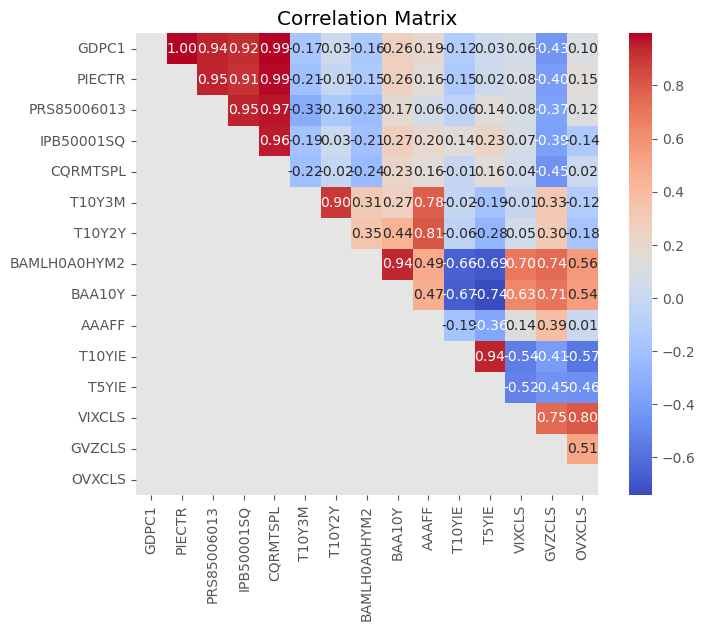

In [52]:

corr_matrix  = dataset_1986.drop(["date","USREC"],axis=1).corr()

mask = np.tril(np.ones_like(corr_matrix , dtype=bool))


plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, square=True)

plt.title('Correlation Matrix')
plt.show()
plt.savefig("img/corr.pdf")
plt.close()


* GDP and PIERCT are very correlated


* **Drop one of them !!!!!!!!**

<AxesSubplot:xlabel='GDPC1', ylabel='PIECTR'>

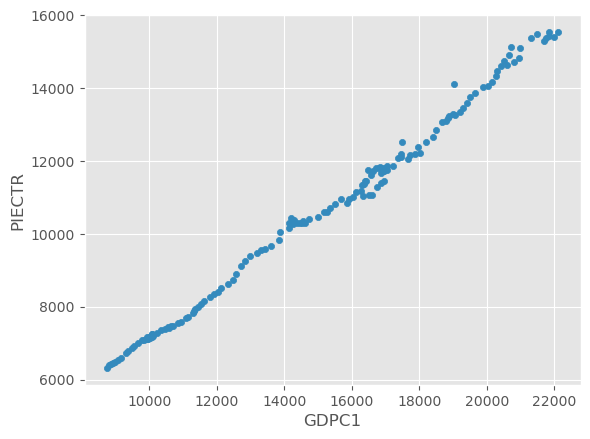

In [53]:
dataset_1986[['GDPC1','PIECTR']].plot(kind='scatter',x='GDPC1',y='PIECTR')

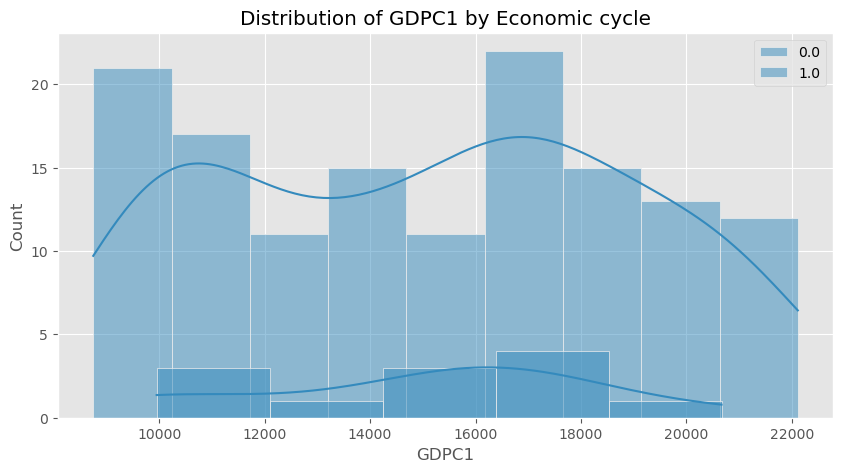

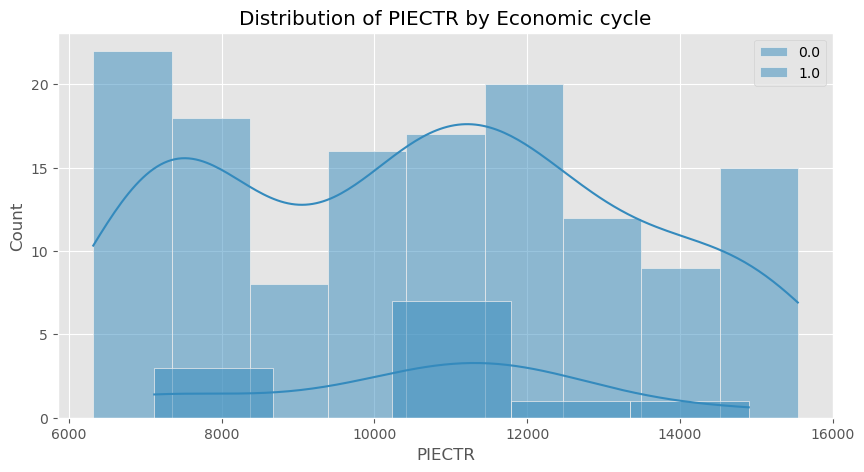

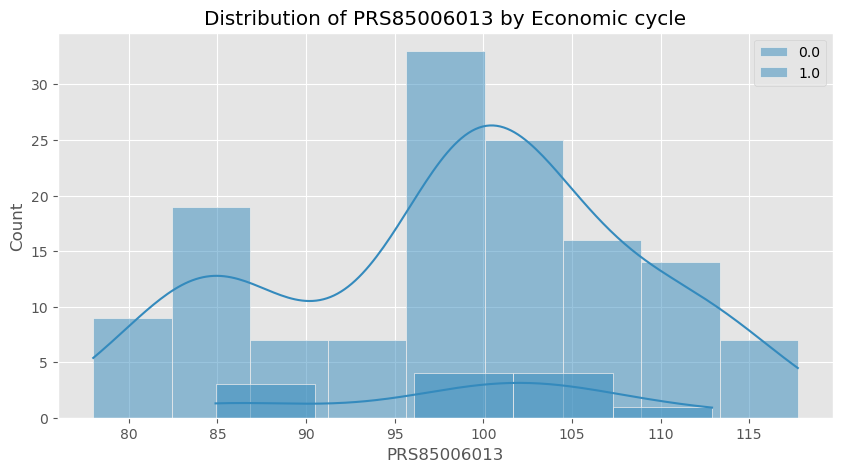

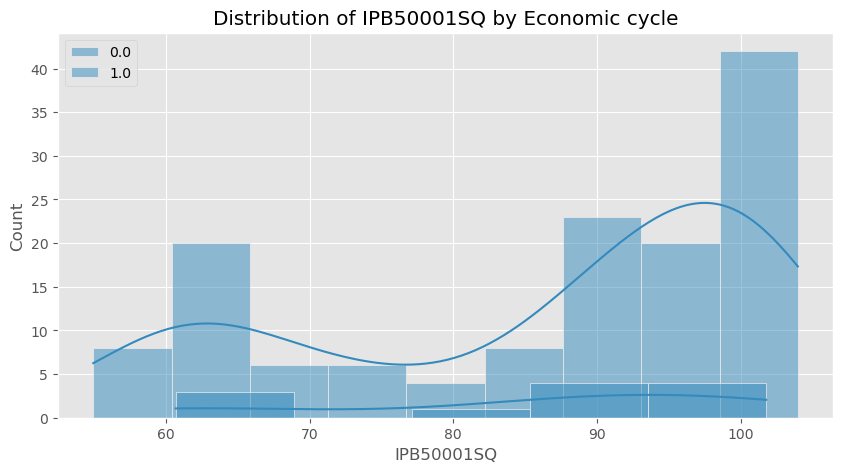

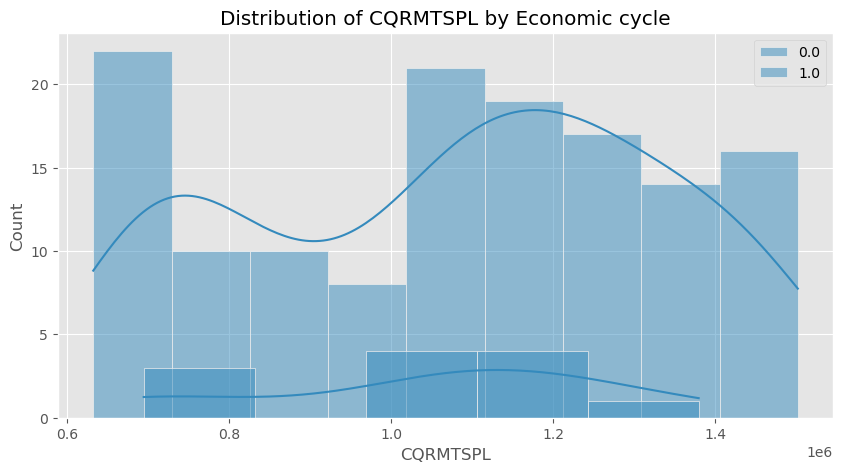

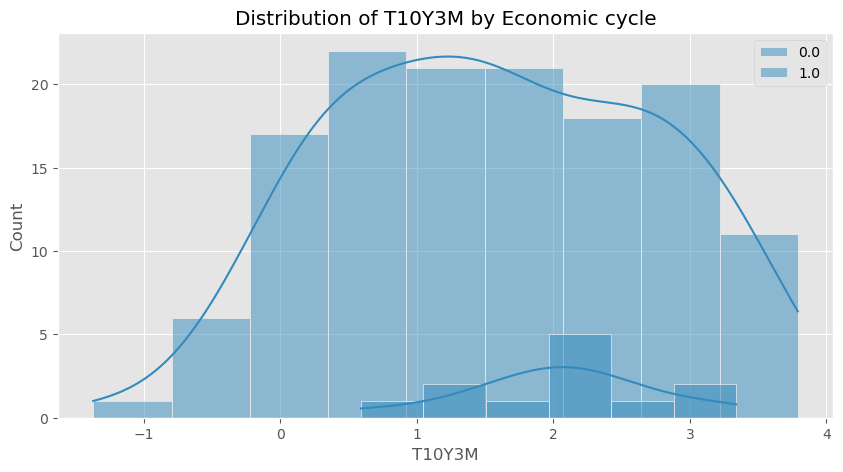

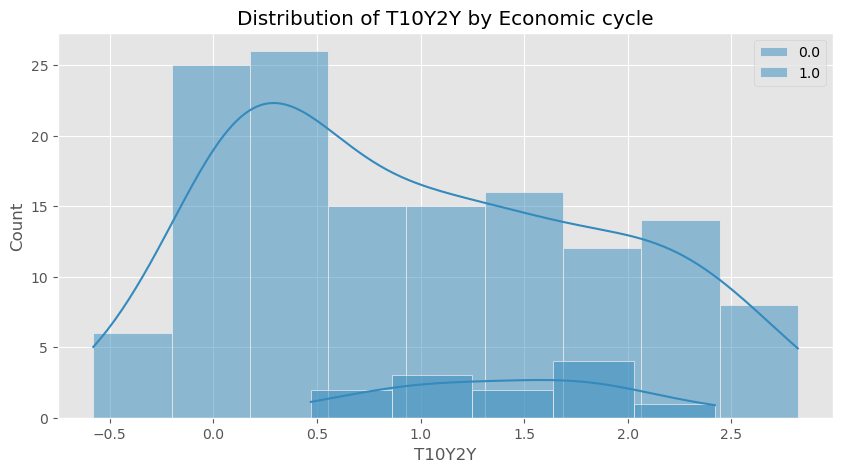

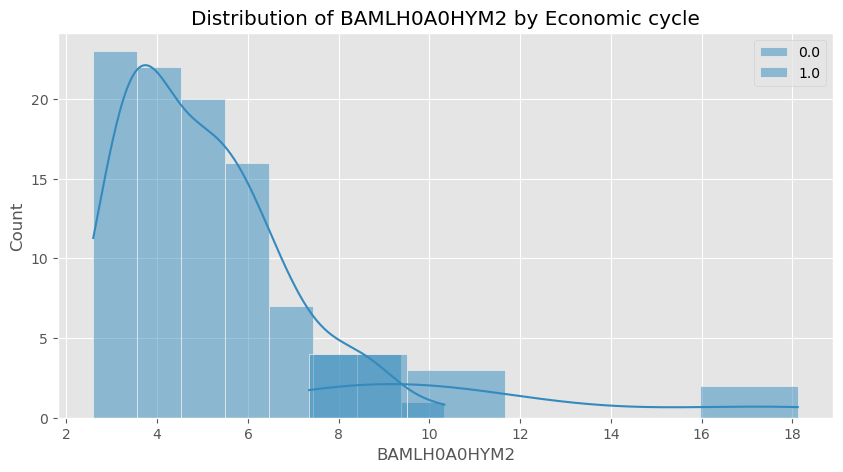

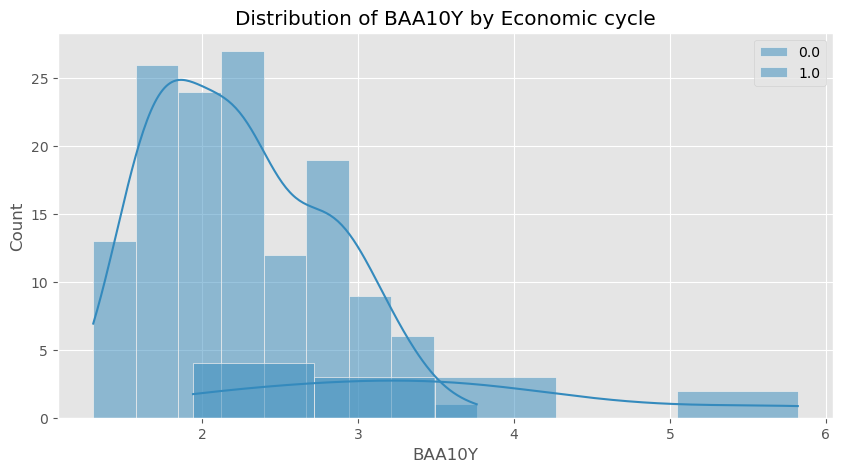

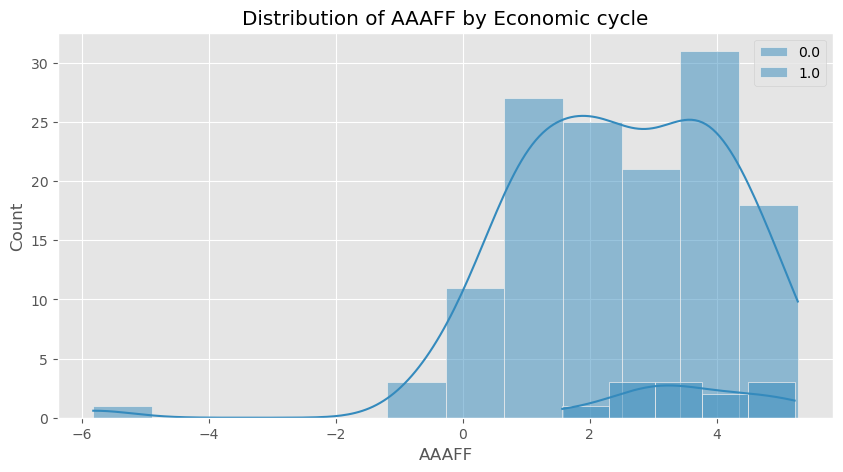

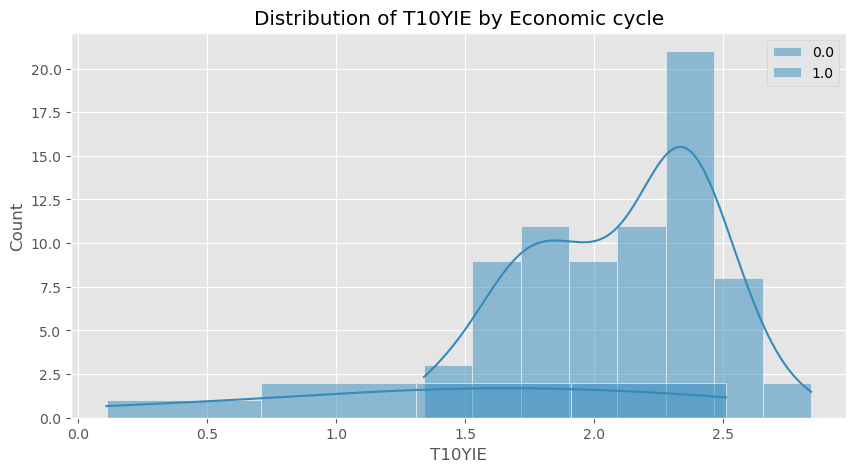

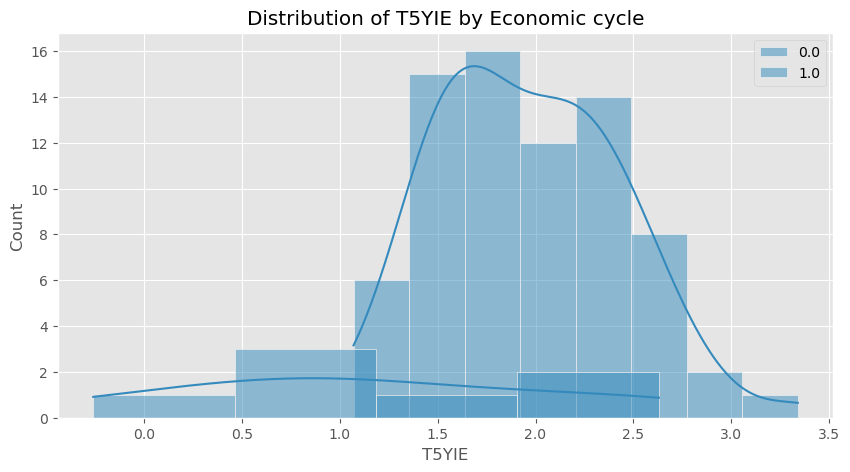

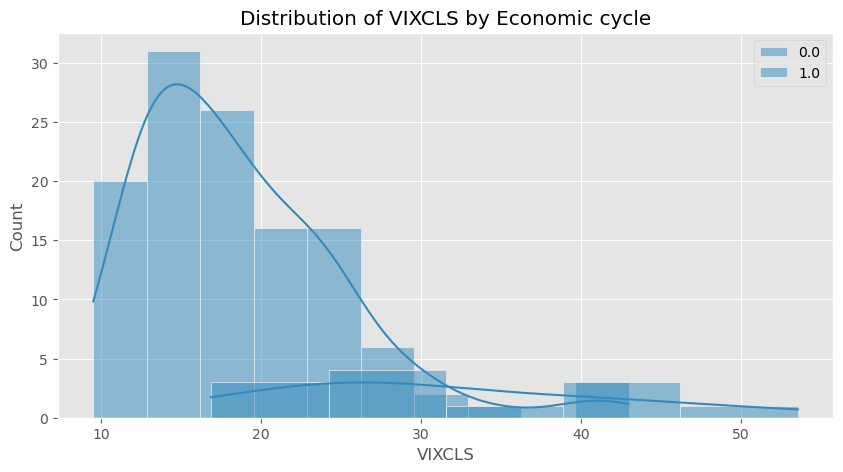

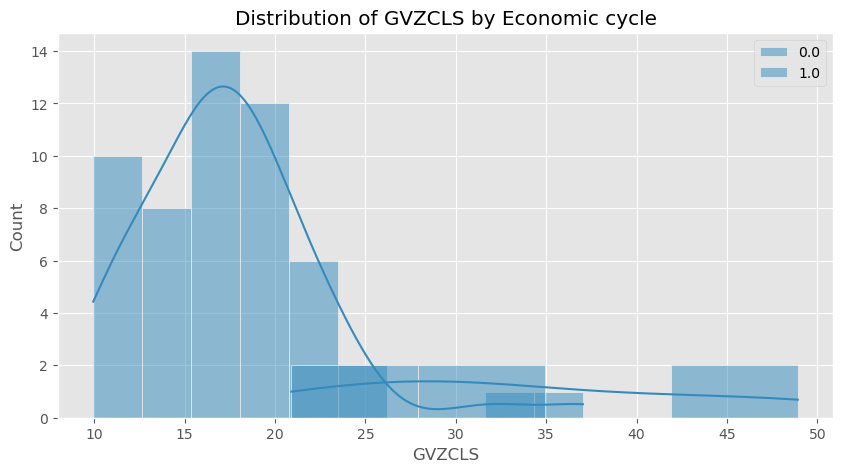

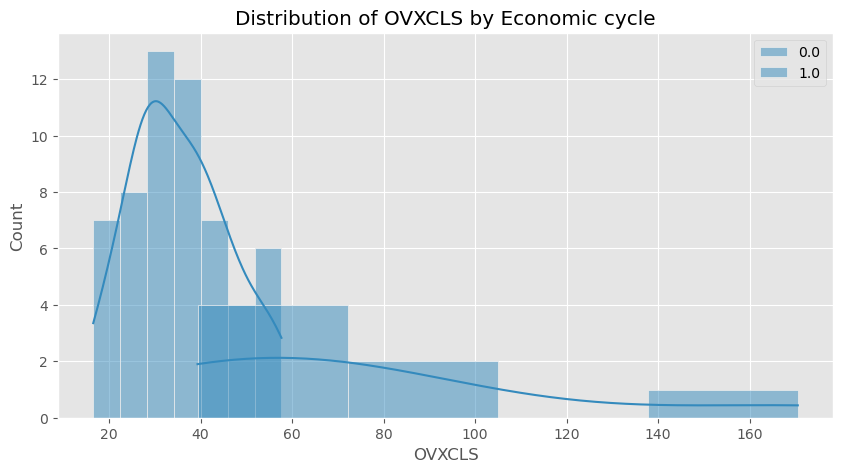

In [54]:

output_directory  ='img'
# Define the numeric columns
numeric_columns = dataset_1986.drop(['date','USREC'],axis=1).columns

# Loop through numeric columns
for col in numeric_columns:
    # Create a new figure for each numeric variable
    plt.figure(figsize=(10, 5))
    
    # Loop through unique classes in the categorical column
    for category in dataset_1986['USREC'].unique():
        # Filter the DataFrame by the current category
        category_data = dataset_1986[dataset_1986['USREC'] == category][col]
        
        # Plot a histogram for the current class
        sns.histplot(category_data, label=category, kde=True)  # You can use sns.histplot or sns.distplot
        
    # Set plot labels, title, and legend
    plt.xlabel(col)
    plt.title(f'Distribution of {col} by Economic cycle')
    plt.legend()
    
    # Show or save the plot
    plt.show()


    # Save the plot as an image in the "Img" folder
    output_path = os.path.join(output_directory, f'{col}_distribution.pdf')
    plt.savefig(output_path)
    
    # Show or clear the plot
    plt.close()
    


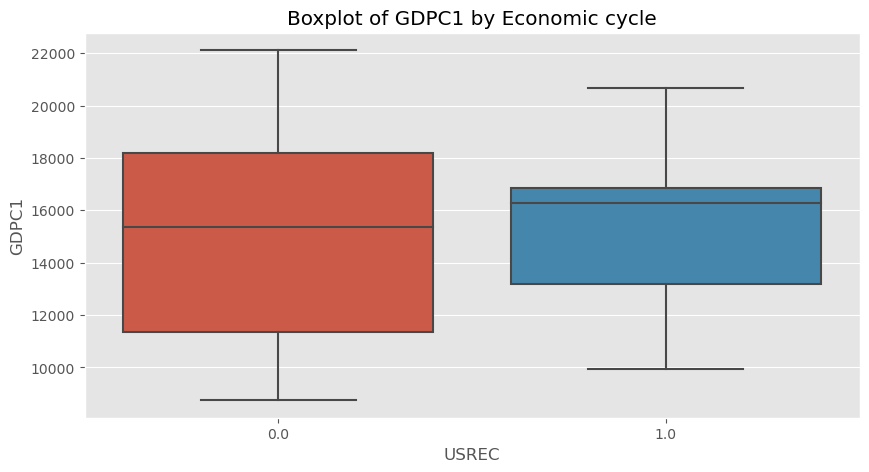

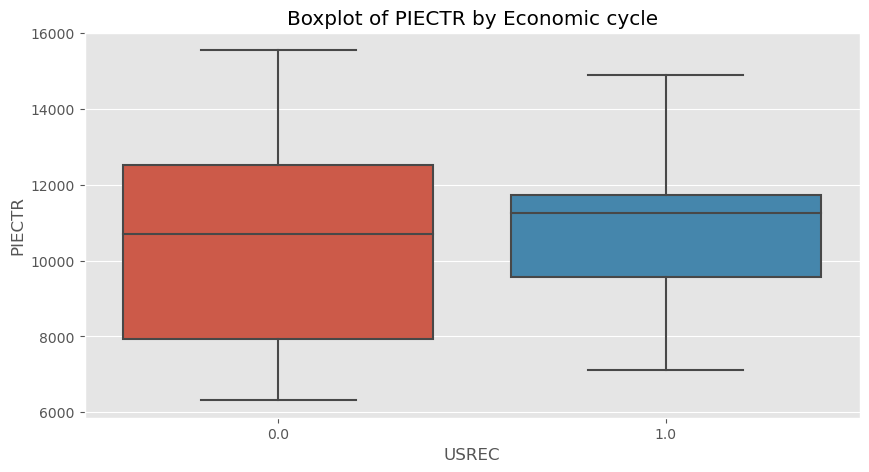

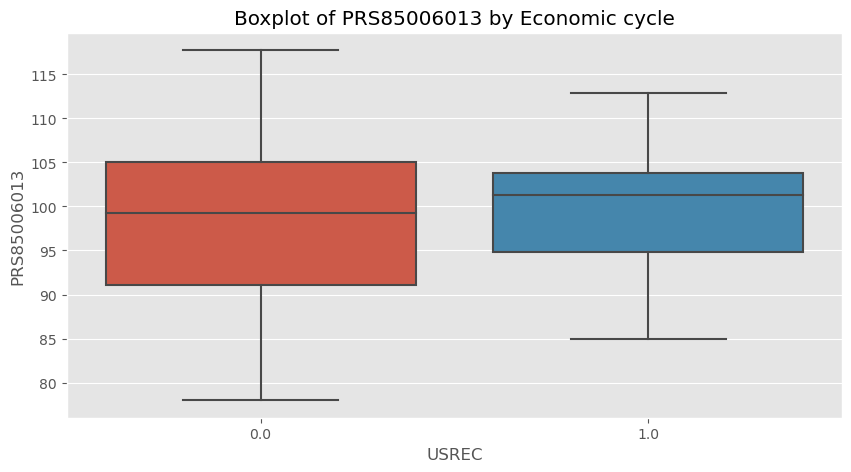

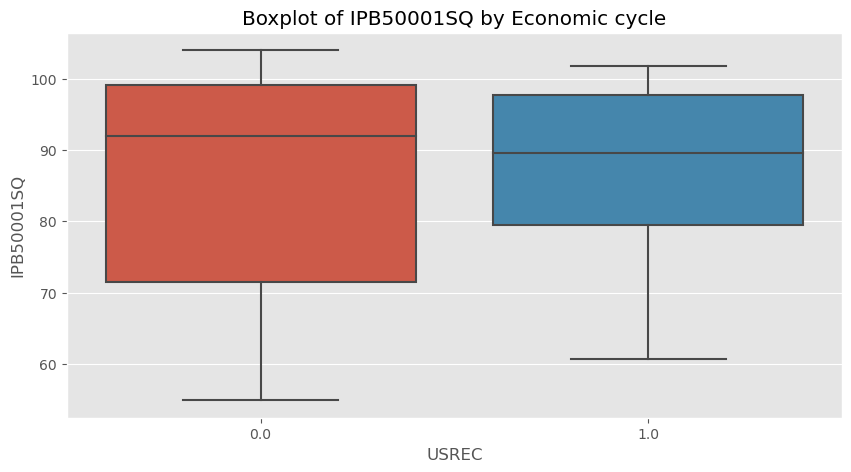

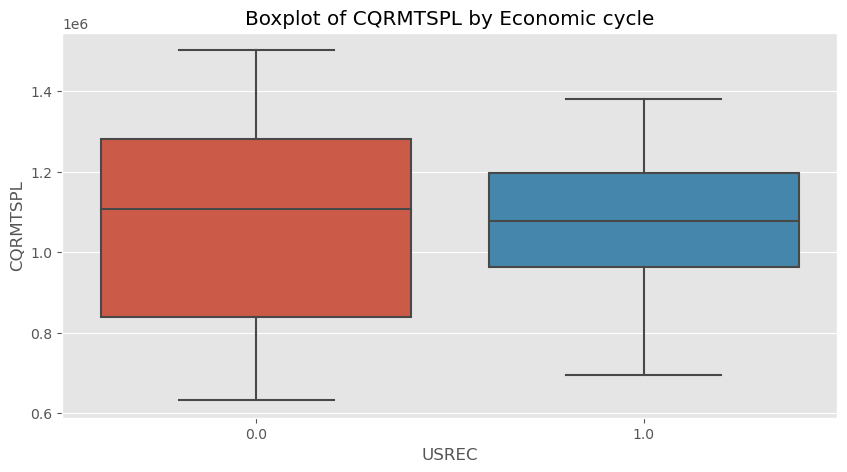

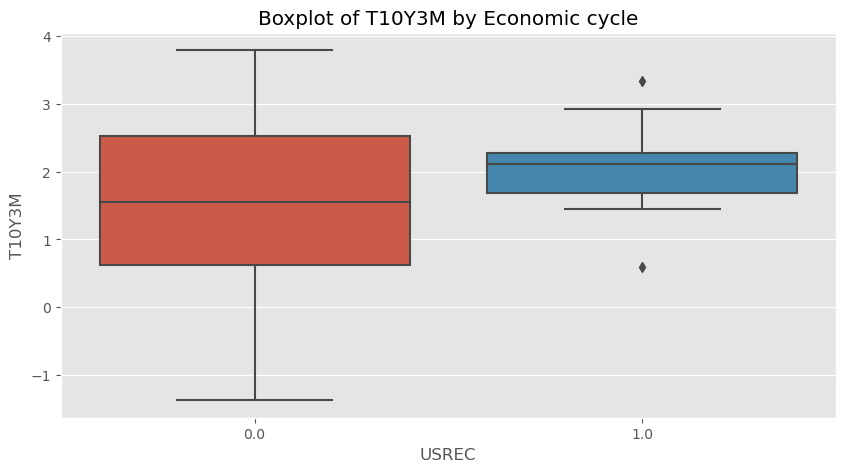

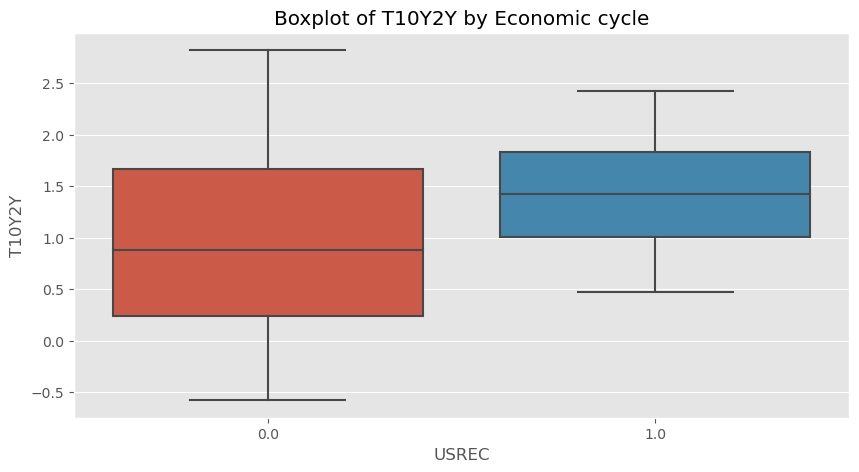

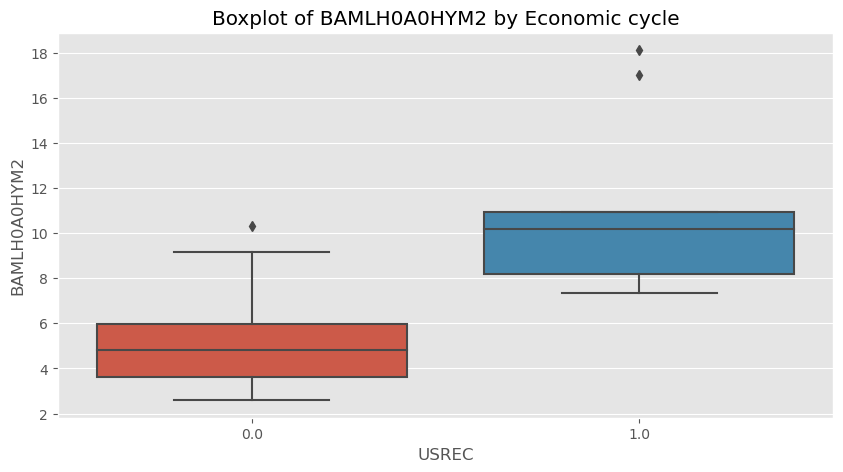

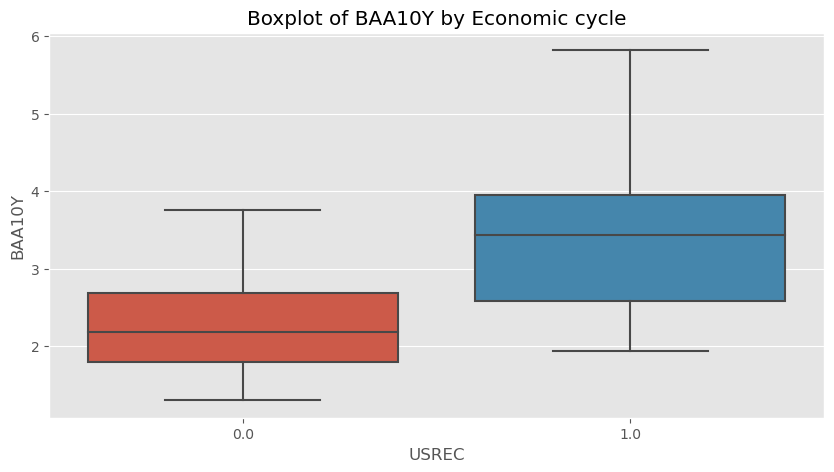

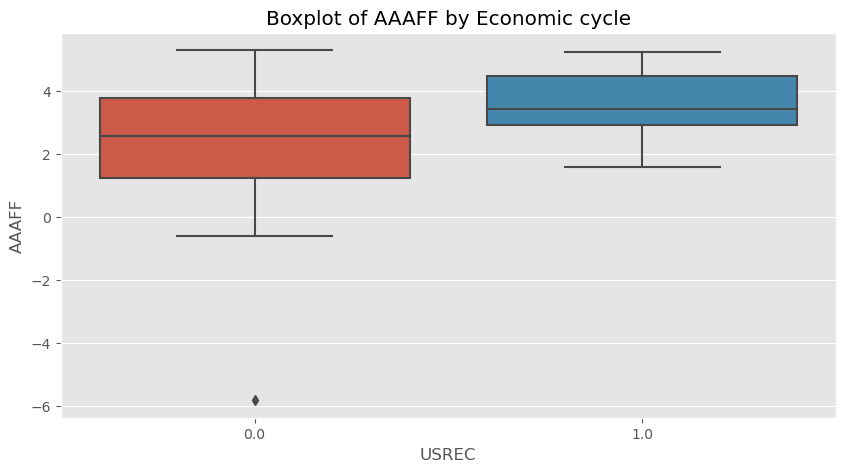

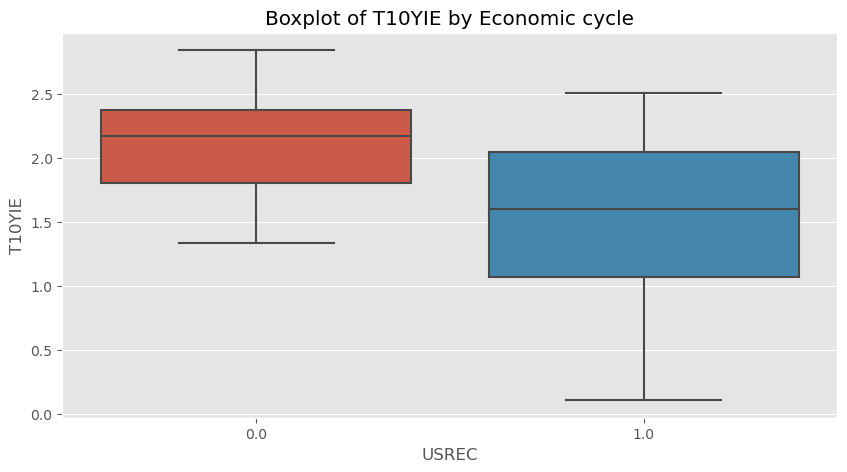

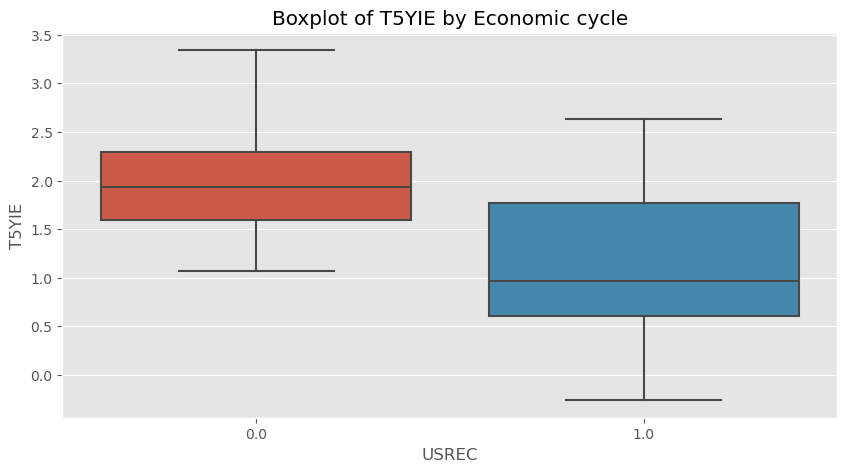

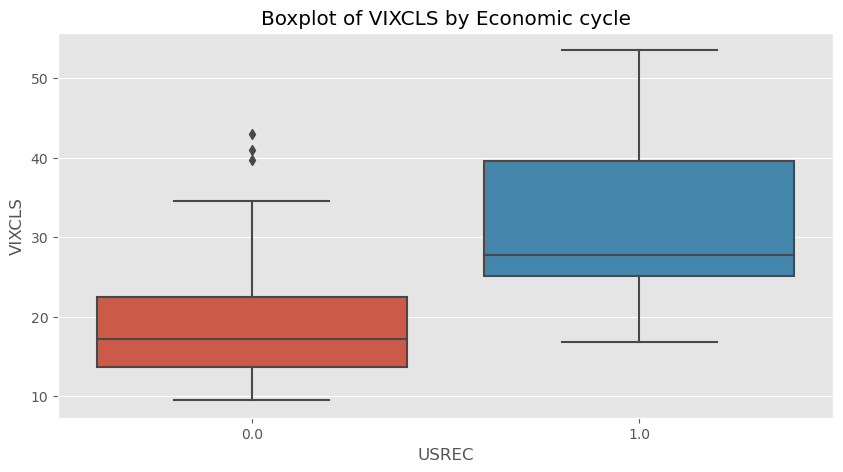

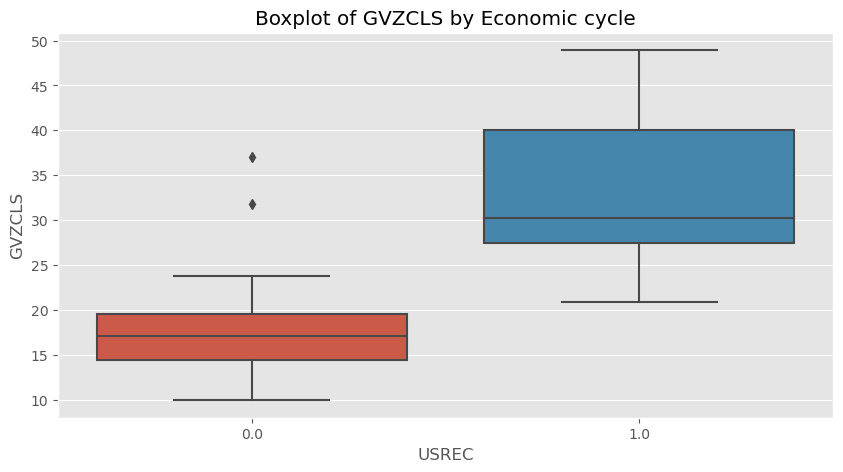

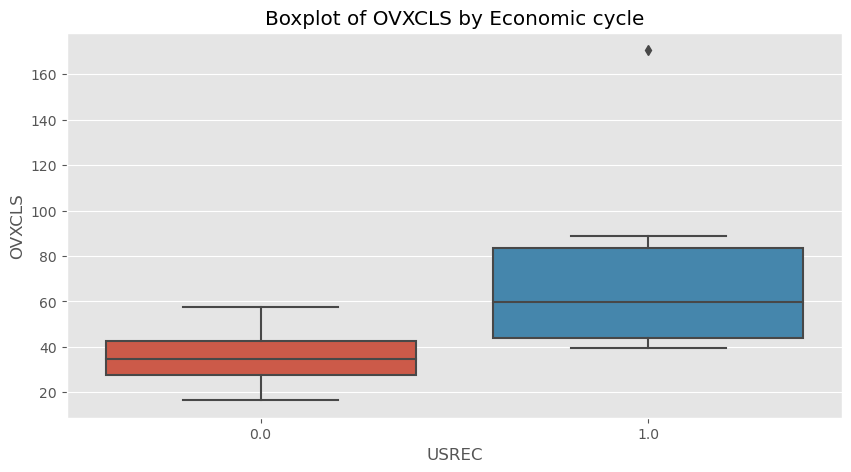

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the numeric columns
numeric_columns = dataset_1986.drop(['date','USREC'],axis=1).columns

# Loop through numeric columns
for col in numeric_columns:
    # Create a new figure for each numeric variable
    plt.figure(figsize=(10, 5))
    
    # Create a boxplot for each numeric variable by category
    sns.boxplot(x='USREC', y=col, data=dataset_1986)
    
    # Set plot labels and title
    plt.xlabel('USREC')
    plt.ylabel(col)
    plt.title(f'Boxplot of {col} by Economic cycle')
    
    # Save the plot as an image in the "Img" folder
    output_path = os.path.join(output_directory, f'{col}_boxplot.pdf')
    plt.savefig(output_path)
    
    # Show or clear the plot
    plt.show()
    plt.close()



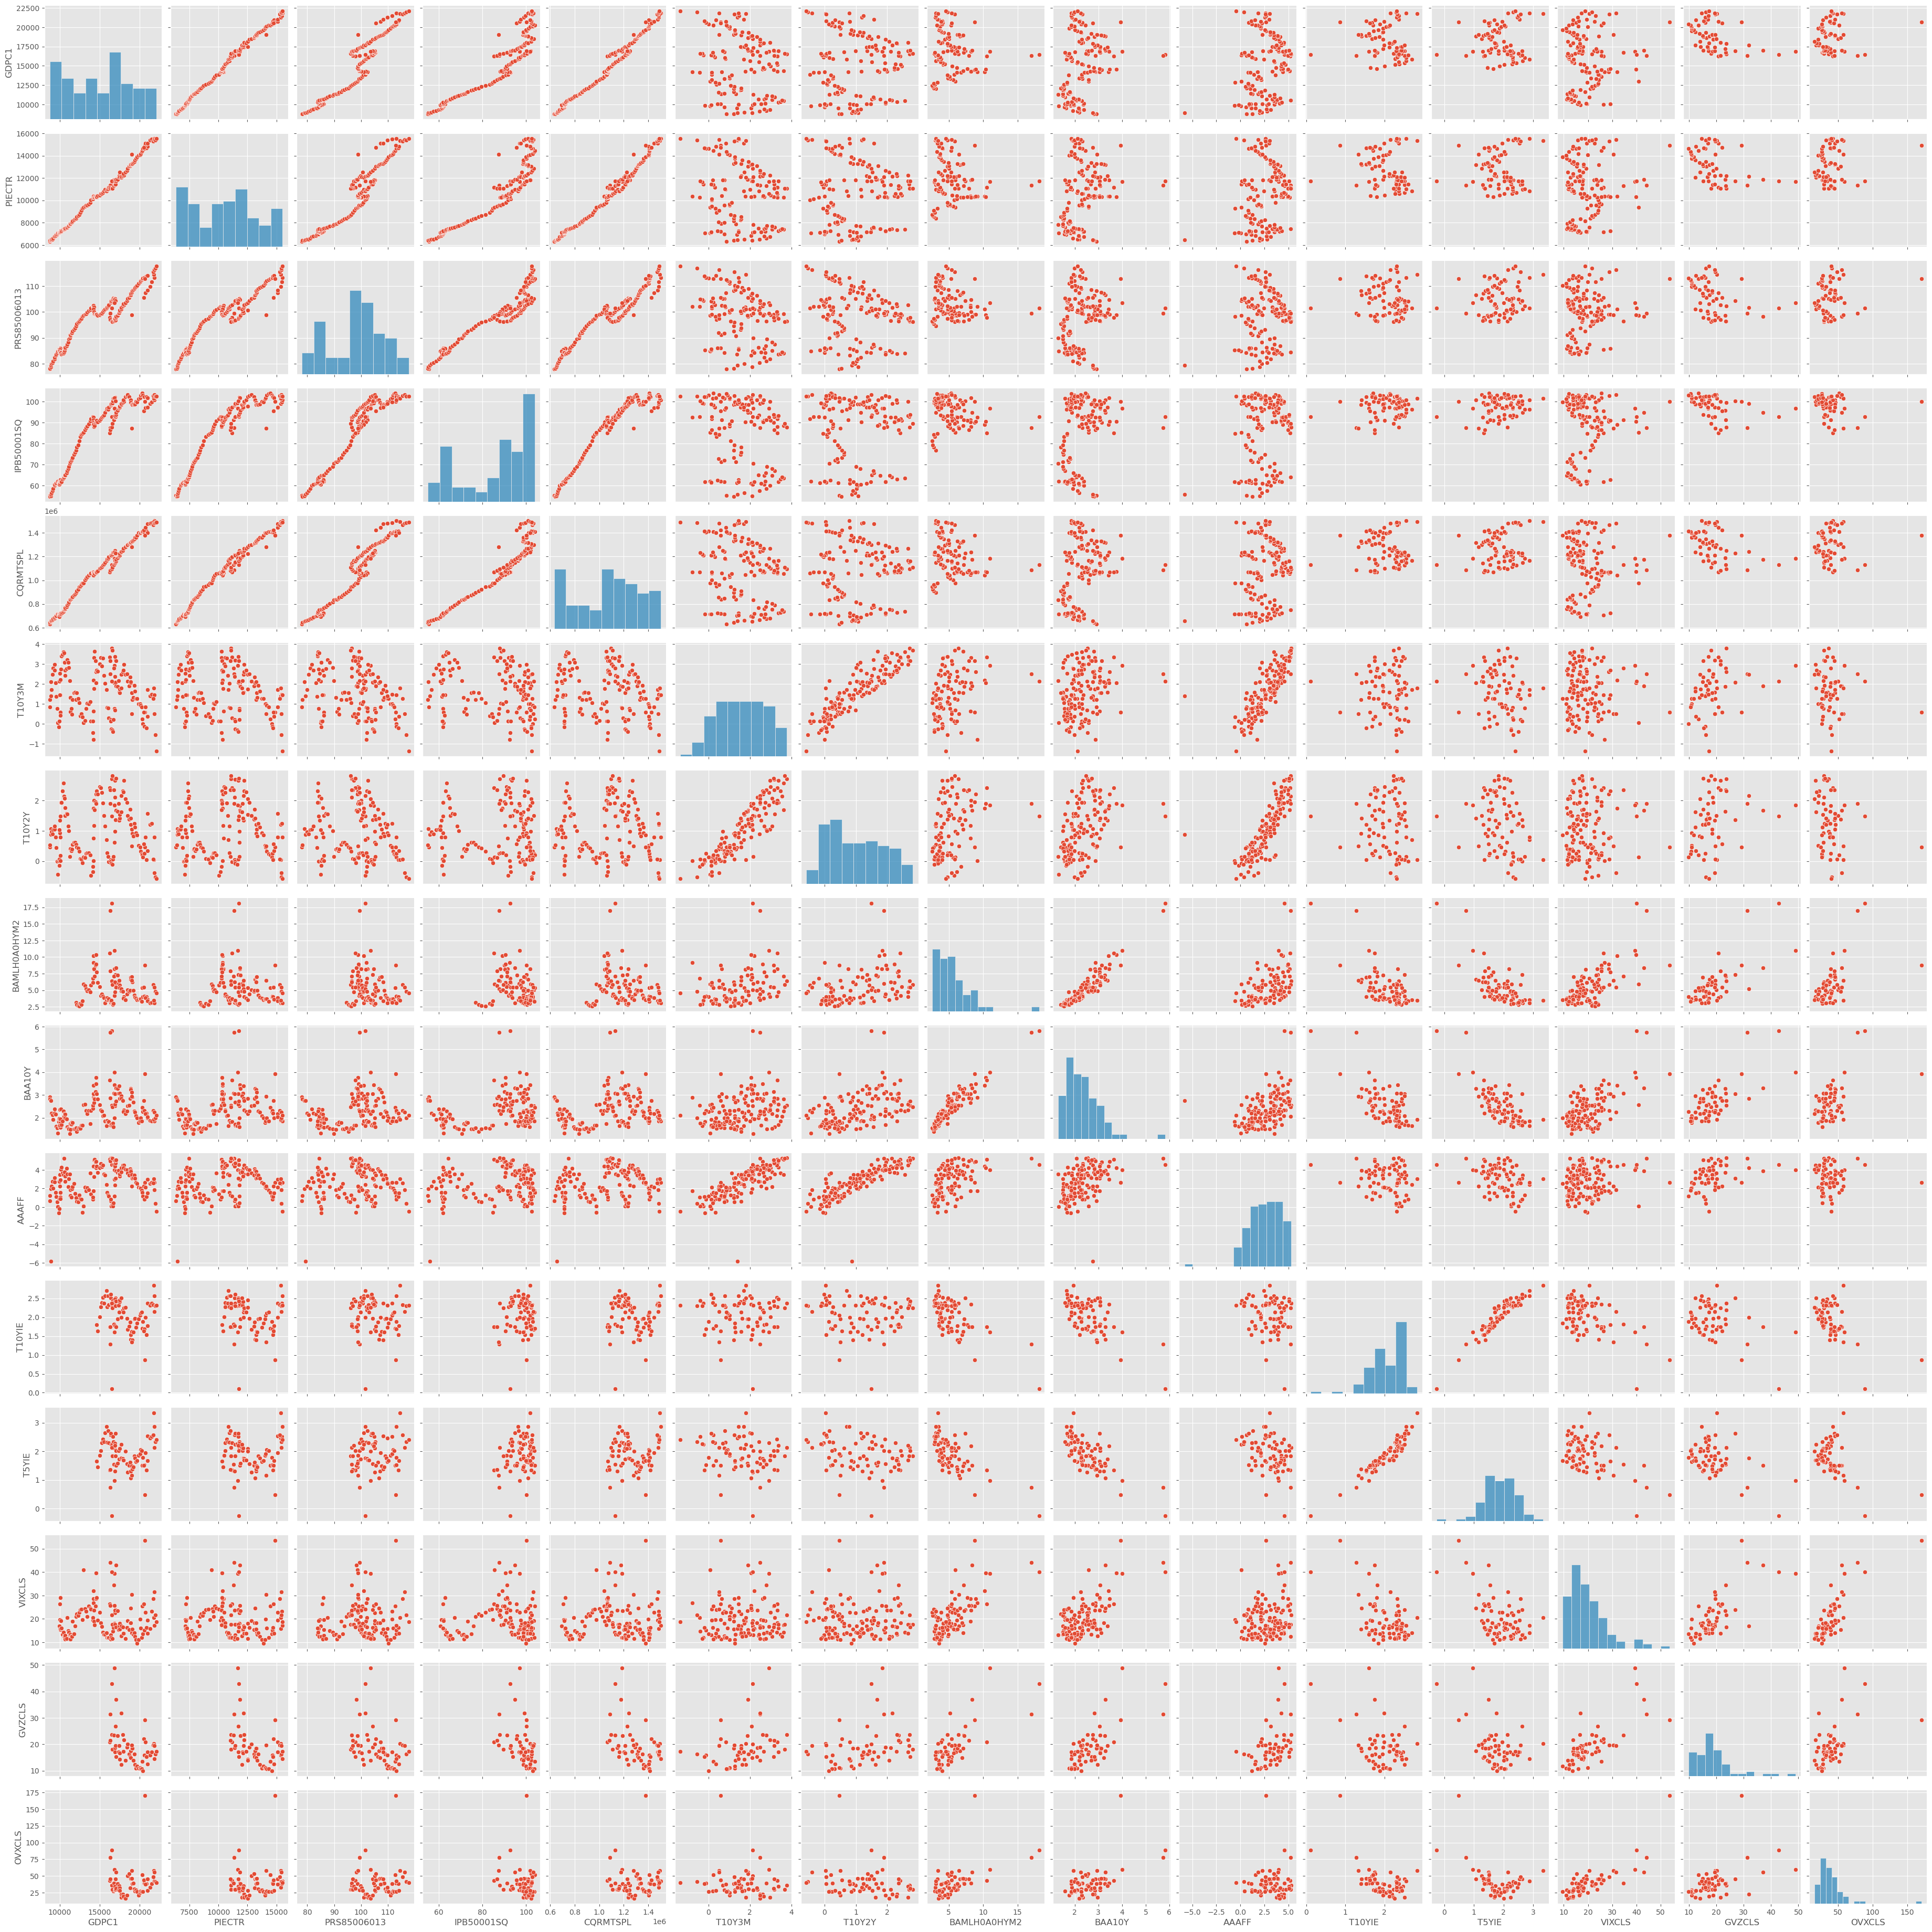

In [56]:
sns.pairplot(dataset_1986.drop(['date','USREC'],axis=1))

* 'T10YIE'e 'T5YIE' bem correlacionados

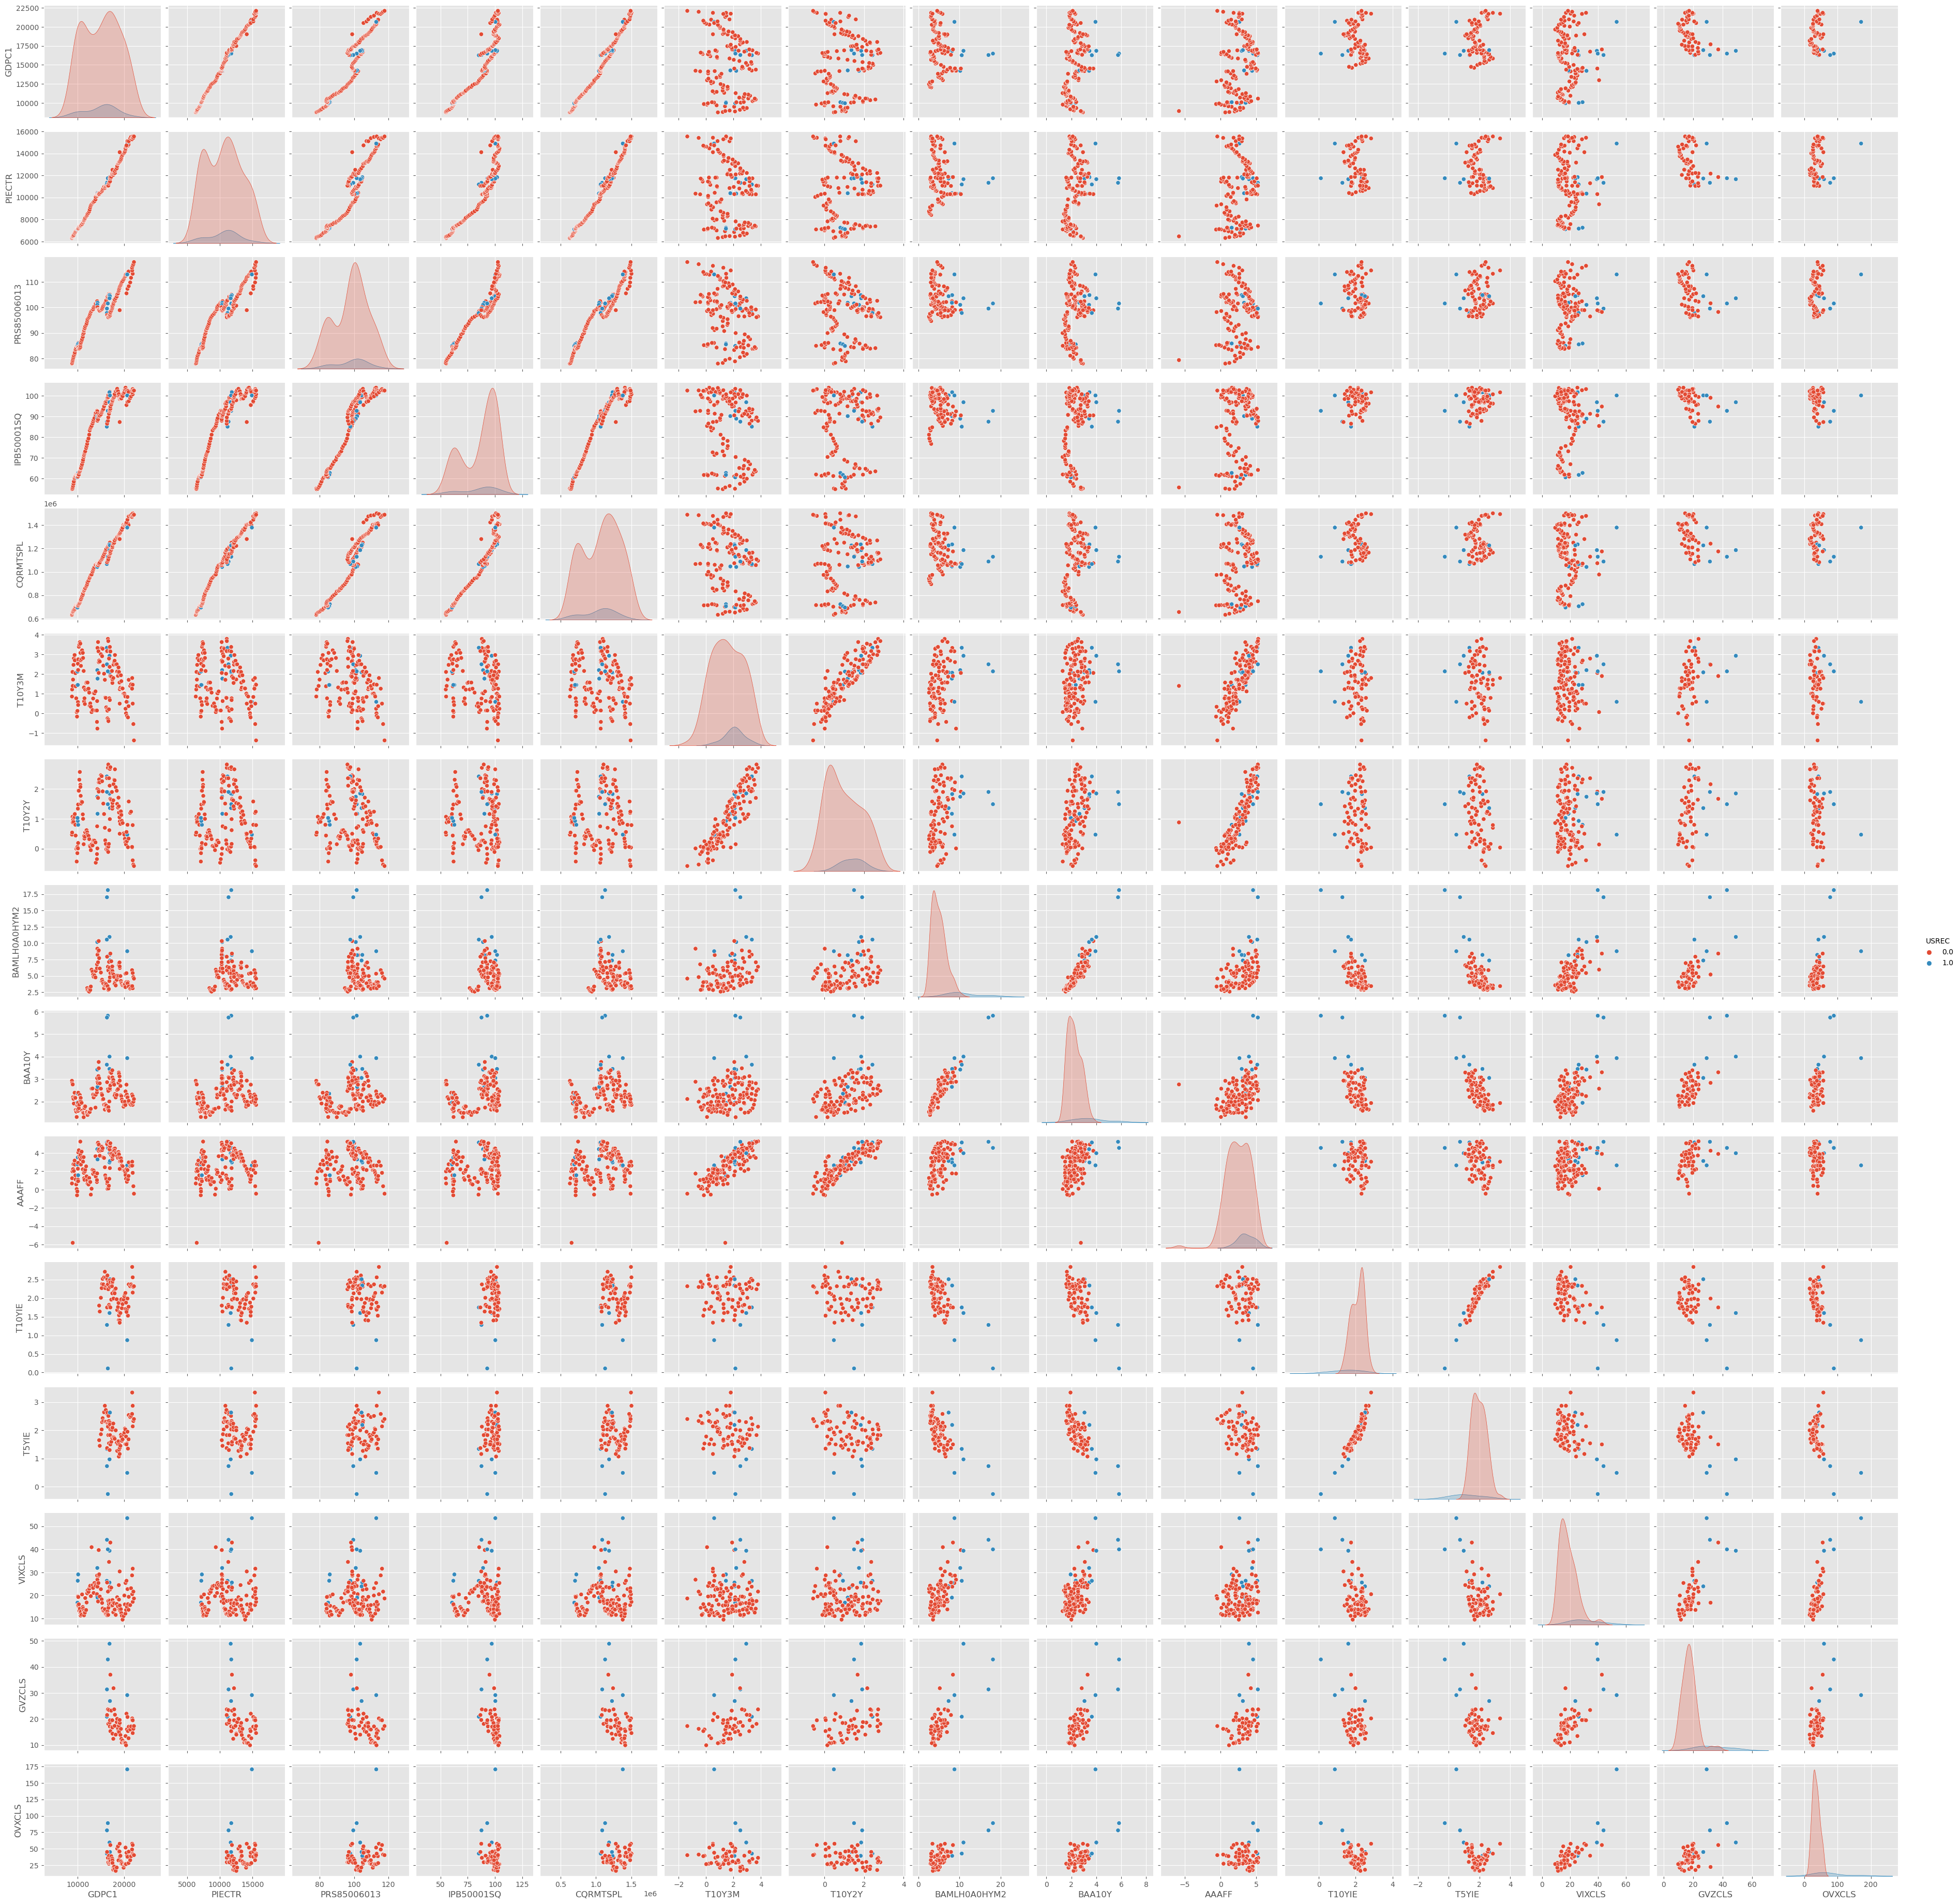

In [57]:
sns.pairplot(dataset_1986.drop(['date'],axis=1),hue='USREC')

In [58]:
dataset_1986.columns

Index(['date', 'USREC', 'GDPC1', 'PIECTR', 'PRS85006013', 'IPB50001SQ',
       'CQRMTSPL', 'T10Y3M', 'T10Y2Y', 'BAMLH0A0HYM2', 'BAA10Y', 'AAAFF',
       'T10YIE', 'T5YIE', 'VIXCLS', 'GVZCLS', 'OVXCLS'],
      dtype='object')

In [62]:
infos[infos['id'] == 'BAA10Y']

id realtime_start realtime_end  \
0  BAA10Y     2023-10-24   2023-10-24   

                                               title observation_start  \
0  Moody's Seasoned Baa Corporate Bond Yield Rela...        1986-01-02   

  observation_end frequency frequency_short    units units_short  \
0      2023-10-23     Daily               D  Percent           %   

       seasonal_adjustment seasonal_adjustment_short            last_updated  \
0  Not Seasonally Adjusted                       NSA  2023-10-24 16:02:02-05   

  popularity                                              notes  
0         75  Series is calculated as the spread between Moo...

Index(['BAMLH0A0HYM2', 'T10YIE', 'VIXCLS', 'GVZCLS', 'OVXCLS'], dtype='object')

In [71]:
pd.DataFrame(dataset_1986.isna().sum()).index

Index(['date', 'USREC', 'GDPC1', 'PRS85006013', 'IPB50001SQ', 'CQRMTSPL',
       'T10Y3M', 'T10Y2Y', 'BAMLH0A0HYM2', 'BAA10Y', 'AAAFF', 'T10YIE',
       'VIXCLS', 'GVZCLS', 'OVXCLS'],
      dtype='object')

In [89]:
# droping redundant columns

redundant = ['T5YIE','PIECTR']

# Many NaNs

cols_NaN = pd.DataFrame(dataset_1986.isna().sum())
cols_NaN.columns = ['Total_NaNs']
cols_NaN.query("Total_NaNs > 0")
too_many_NaNs_cols = cols_NaN.query("Total_NaNs > 0").index
too_many_NaNs_cols = too_many_NaNs_cols.tolist()


remove_cols = redundant + too_many_NaNs_cols
remove_cols


['T5YIE',
 'PIECTR',
 'BAMLH0A0HYM2',
 'T10YIE',
 'T5YIE',
 'VIXCLS',
 'GVZCLS',
 'OVXCLS']

In [90]:
dataset_1986.drop(remove_cols,axis=1,inplace=True)

--------------------
# Modeling 

- Mantain the dataset order or shuffle?
- Normalize a all dataset ? What about data leakage ?
- Take the first difference  (log) 

In [108]:
from utils.preprocessing_machine_learning import preprocess_dataframe
from utils.metrics import * 

In [104]:
from sklearn.tree import DecisionTreeClassifier

#dataset_dif_model = preprocess_dataframe(dataset_1986, preprocess_type='log_difference', exclude_columns=['date','USREC','T10Y3M','T10Y2Y','AAAFF'])
dataset_dif_model = preprocess_dataframe(dataset_1986, preprocess_type='normalize', exclude_columns=['date','USREC'])
dataset_dif_model = dataset_dif_model.iloc[1:,:]




dataset_dif_model.set_index("date",inplace=True)

X = dataset_dif_model.drop("USREC", axis = 1)
y = dataset_dif_model["USREC"]


SPLIT = 0.7
SEED=42


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = SPLIT , random_state =  SEED)



In [105]:

mod_arvore1 = DecisionTreeClassifier()

mod_arvore1.fit(X_train, y_train) # essa é a linha que treina o modelo!!!!

# Prediçoes para o teste

y_pred_test = mod_arvore1.predict(X_test)

In [109]:
get_metrics(mod_arvore1,y_test,X_test)

{'Accuracy': 0.8444444444444444,
 'Precision': 0.0,
 'Recall': 0.0,
 'F1-Score': 0.0,
 'False Positive Ratio': array([0.       , 0.0952381, 1.       ]),
 'True Positive Ratio': array([0., 0., 1.]),
 'Thresholds': array([2., 1., 0.]),
 'Area Under the Curve': 0.4523809523809524,
 'Gini': -0.1,
 'Confussion Matrix': array([[38,  4],
        [ 3,  0]]),
 'Classification Report': '              precision    recall  f1-score   support\n\n         0.0       0.93      0.90      0.92        42\n         1.0       0.00      0.00      0.00         3\n\n    accuracy                           0.84        45\n   macro avg       0.46      0.45      0.46        45\nweighted avg       0.87      0.84      0.85        45\n'}

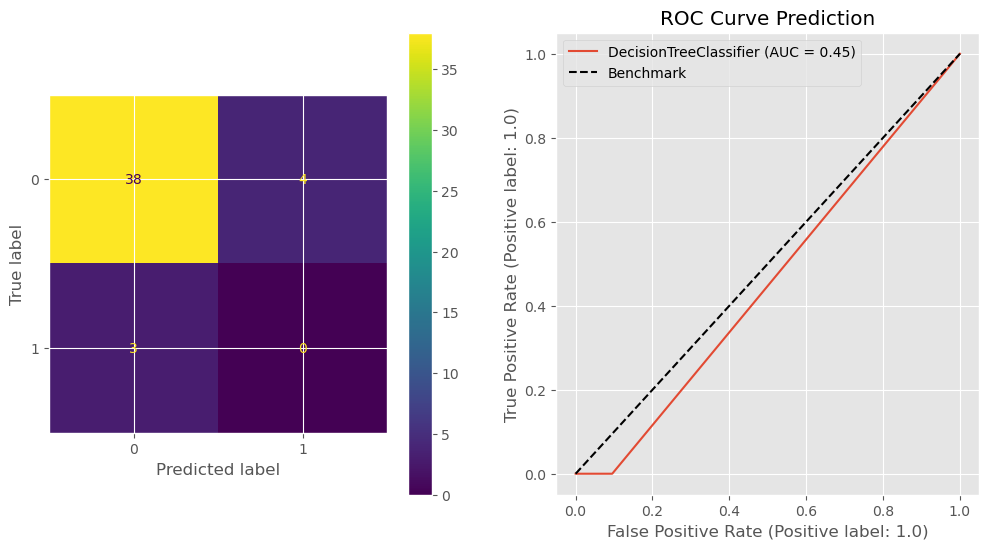

In [110]:
plot_classification_metrics(mod_arvore1,y_test,X_test)